## **1. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **2. Import the necessary libraries**
---

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.5.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [3]:
!pip install keras-tuner
from keras.utils import np_utils
from kerastuner.tuners import RandomSearch
import kerastuner as kt

     |████████████████████████████████| 96 kB 3.3 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=5d642d7abf70d581b7046ce13c2b3555938ffb4bc0f9b406aa62a4bdf7d41623
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


## **3.Create a function to plot image without axis**
---

In [4]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

<function implt at 0x7f50d9cebe60>


## **4. Set matplotlib to have seaborn plot style**
---

In [5]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **5. Prepare Cifar10 data for training and testing**
---
* Step 1: Load the cifar10 
* Step 2: Check the shape and type of the data
* Step 3: Convert the data into float32 and rescale the values from the range of 0\~255 into 0\~1
* Step 4: Retrieve the row size and the column size of each image
* Step 5: Perform one-hot enconding on the labels
* Step 6: Retrieve the number of classes in this problem

In [6]:
                                                                                # Step 1
data            = cifar10.load_data()
(trDat, trLbl)  = data[0]
(tsDat, tsLbl)  = data[1]

                                                                                # Step 2
print("The shape of trDat is", trDat.shape, "and the type of trDat is", trDat.dtype)
print("The shape of tsDat is", tsDat.shape, "and the type of tsDat is", tsDat.dtype)
print("")
print("The shape of trLbl is", trLbl.shape, "and the type of trLbl is", trLbl.dtype)
print("The shape of tsLbl is", tsLbl.shape, "and the type of tsLbl is", tsLbl.dtype)

                                                                                # Step 3
trDat           = trDat.astype('float32')/255
tsDat           = tsDat.astype('float32')/255

                                                                                # Step 4
imgrows         = trDat.shape[1]
imgclms         = trDat.shape[2]
channel         = trDat.shape[3]

                                                                                # Step 5
trLbl           = to_categorical(trLbl)
tsLbl           = to_categorical(tsLbl)
                               
num_classes     = tsLbl.shape[1]                                                # Step 6

170500096/170498071 [==============================] - 2s 0us/step
The shape of trDat is (50000, 32, 32, 3) and the type of trDat is uint8
The shape of tsDat is (10000, 32, 32, 3) and the type of tsDat is uint8

The shape of trLbl is (50000, 1) and the type of trLbl is uint8
The shape of tsLbl is (10000, 1) and the type of tsLbl is uint8


## **6. Define deep learning model**
___
* Step 1: Setup the optimizer to be used for training
* Step 2: Set a name for the coming model (required for saving)
* Step 3: Define the convolutional neural network model
* Step 4: Create models for training and testing
* Step 5: Display the summary of the model of interest 

In [7]:
def create_model(hyperparam):

  model = Sequential()

  model.add(Conv2D(filters = hyperparam.Int('convolution_1',min_value=30, max_value=60, step=10), 
                          kernel_size = hyperparam.Choice('convolution_1', values = [3,5]),
                          activation='relu',
                          padding='same',
                          input_shape=(imgrows,imgclms,channel) ))
            
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters = hyperparam.Int('convolution_2',min_value=30, max_value=60, step=10), 
                          kernel_size = hyperparam.Choice('convolution_2', values = [3,5]),
                          activation='relu',
                   padding='same'))

  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  for i in range(hyperparam.Int('num_layers', 1, 3)):
    model.add(Dense(units = hyperparam.Int('units_' + str(i),min_value=32,max_value=256,step=32),
                    activation = 'relu'))

  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer = optimizers.RMSprop(lr=0.0001),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [8]:
tuner_search=RandomSearch(create_model,
                       objective='val_accuracy',
                      max_trials=3,
                      directory='output',
                       project_name="mnist")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner_search.search(trDat, trLbl, epochs = 20, validation_data=(tsDat, tsLbl), callbacks=[stop_early])

Trial 3 Complete [00h 59m 22s]
val_accuracy: 0.5906999707221985

Best val_accuracy So Far: 0.5940999984741211
Total elapsed time: 03h 12m 40s
INFO:tensorflow:Oracle triggered exit


In [9]:
tuner_search.search_space_summary()

Search space summary
Default search space size: 5
convolution_1 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 60, 'step': 10, 'sampling': None}
convolution_2 (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 60, 'step': 10, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}


In [10]:
modelname   = 'wks2_3' 

model = tuner_search.get_best_models(num_models=1)[0] # This is meant for training
modelGo = tuner_search.get_best_models(num_models=1)[0] # This is used for final testing

model.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 40)        192040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 50)        5000050   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               409728    
_________________________________________________________________
dense_1 (Dense)              (None, 96)                1

## **7. Create the callbacks to be applied during training**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callbacks objects into a list

In [13]:
                                                                                # Step 1
folderpath      = '/content/gdrive/My Drive/iss/prumls/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger,stop_early]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/iss/prumls/colab/wks2_3.hdf5
Path to log:   /content/gdrive/My Drive/iss/prumls/colab/wks2_3.csv


## **8. Train the deep learning model**
___

In [14]:
model.fit(trDat,                            # Training data
          trLbl,                            # Training label
          validation_data=(tsDat, tsLbl),   # Validation data and label
          epochs=100,                       # The amount of epochs to be trained
          batch_size=128,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/100
391/391 [==============================] - 225s 574ms/step - loss: 0.1786 - accuracy: 0.9465 - val_loss: 1.8442 - val_accuracy: 0.5948
Epoch 2/100
391/391 [==============================] - 224s 573ms/step - loss: 0.1521 - accuracy: 0.9550 - val_loss: 2.0556 - val_accuracy: 0.5879
Epoch 3/100
391/391 [==============================] - 224s 573ms/step - loss: 0.1313 - accuracy: 0.9612 - val_loss: 1.9821 - val_accuracy: 0.5884
Epoch 4/100
391/391 [==============================] - 224s 573ms/step - loss: 0.1107 - accuracy: 0.9682 - val_loss: 2.1363 - val_accuracy: 0.5938
Epoch 5/100
391/391 [==============================] - 224s 573ms/step - loss: 0.0970 - accuracy: 0.9717 - val_loss: 2.1695 - val_accuracy: 0.5993
Epoch 6/100
391/391 [==============================] - 224s 573ms/step - loss: 0.0843 - accuracy: 0.9764 - val_loss: 2.3185 - val_accuracy: 0.5841


## **9. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction


In [15]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(lr=0.0001), 
                metrics=['accuracy'])

predicts    = modelGo.predict(tsDat)                                            # Step 2
print("Prediction completes.")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Prediction completes.


## **10. Report classification metrics**
---
* Step 1: Setup the label
* Step 2: Convert label from one-hot to integer
* Step 3: Calculate the accuracy score
* Step 4: Generate classification report

In [16]:
                                                                                # Step 1
labelname   = ['airplane',          # The label for reporting metrics
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 59.93%
              precision    recall  f1-score   support

    airplane     0.7030    0.6580    0.6798      1000
  automobile     0.7422    0.6880    0.7141      1000
        bird     0.4488    0.5350    0.4881      1000
         cat     0.4197    0.4340    0.4267      1000
        deer     0.6386    0.3710    0.4693      1000
         dog     0.4864    0.5190    0.5022      1000
        frog     0.6784    0.6370    0.6570      1000
       horse     0.6344    0.7010    0.6660      1000
        ship     0.6761    0.7680    0.7191      1000
       truck     0.6297    0.6820    0.6548      1000

    accuracy                         0.5993     10000
   macro avg     0.6057    0.5993    0.5977     10000
weighted avg     0.6057    0.5993    0.5977     10000



## **11. Print confusion matrix**
---

In [17]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[658  25  70  14  15  15  20  28 106  49]
 [ 30 688  22  15   5  13  10   8  67 142]
 [ 61  21 535  73  61  83  60  62  23  21]
 [ 25  16 104 434  31 195  75  55  20  45]
 [ 27   7 196  90 371  71  77 113  28  20]
 [ 14   8  84 202  27 519  37  75  19  15]
 [  6  15  80 110  29  66 637  17  18  22]
 [ 23   7  62  50  27  71  14 701  11  34]
 [ 61  40  21  23   8   8   6  12 768  53]
 [ 31 100  18  23   7  26   3  34  76 682]]


## **12. Plot curves on validation loss and accuracy**
---

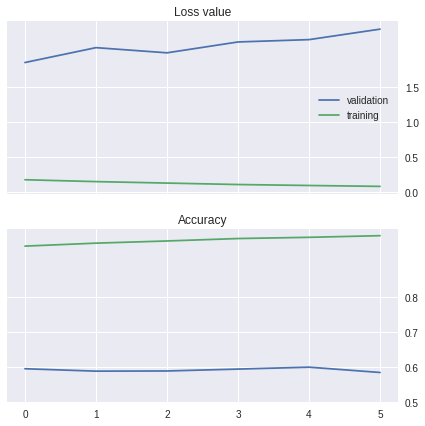

In [18]:
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **13. Save the model plot**
---

In [19]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/iss/prumls/colab/wks2_3_plot.png
